In [1]:
import sys
import os

sys.path.append("..")

import torch

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn import Module, MSELoss, L1Loss

import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

from dataset import  KeypointDataset

from model import KeypointNet

from trainer import TrainingParameters, train

import utils

In [2]:
imgsPath = "../data/imgs"
jsonPath = "../data/json"

dataset = KeypointDataset(jsonPath, imgsPath,0,0,0)

In [3]:
print(len(dataset))

1237


In [4]:
# preparing dataloaders
TRAIN_SIZE = int(0.7*len(dataset))
VALID_SIZE = int(0.2*len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE - VALID_SIZE
BATCH_SIZE = 128

# random split the data
trainDataset, valDataset, testDataset = random_split(dataset, [TRAIN_SIZE, VALID_SIZE, TEST_SIZE])

# creating dataloaders
trainLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

# sanity check
print('='*30)
print("Train dataset", len(trainDataset))
print("Valid dataset", len(valDataset))
print("Test dataset", len(testDataset))

Train dataset 865
Valid dataset 247
Test dataset 125


[0.29999998 0.72       0.34       0.55       0.39000002 0.33
 0.46       0.11       0.55       0.11       0.64       0.32
 0.7        0.53       0.71999997 0.69      ]
[[23 57]
 [27 44]
 [31 26]
 [36  8]
 [44  8]
 [51 25]
 [56 42]
 [57 55]]


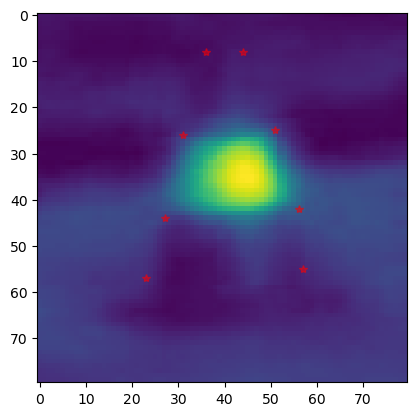

In [5]:
# sanity check
imgs, labels = next(iter(testLoader))
i = 0
bs, _, height, width = imgs.shape
kps = labels[i].cpu().detach().numpy()
print(kps)
kps = kps.reshape(-1,2)
kps[:,0] = kps[:,0]*width
kps[:,1] = kps[:,1]*height
kps = kps.astype(int)

img = utils.showImageTensor(imgs[i], show=False)
for point1 in kps:
    plt.plot(*point1, marker='*', color='red', alpha=0.5)
print(kps)
plt.show()

In [6]:
class CrossRatioLoss(Module):
    EPSILON = 1e-7
    
    def __init__(self):
        super().__init__()
        
    def forward(self, y1, y2):
        y1 = y1.view(-1,8,2)
        y2 = y2.view(-1,8,2)
        
        # extract slant heights
        leftSlantPointsPreds = y1[:,:4,:]
        leftSlantPointsGT = y2[:,:4,:]
        rightSlantPointsPreds = y1[:,4:,:]
        rightSlantPointsGT = y2[:,4:,:]
        #print(leftSlantPointsPreds.shape, leftSlantPointsGT.shape, rightSlantPointsPreds.shape,\
        #rightSlantPointsGT.shape)
        
        # cone top (p1)
        topLeftPointPreds = leftSlantPointsPreds[:,-1,:]
        topRightPointPreds = rightSlantPointsPreds[:,0,:]
        topLeftPointGT = leftSlantPointsGT[:,-1,:]
        topRightPointGT = rightSlantPointsGT[:,0,:]
        
        p1Preds = ((topLeftPointPreds+topRightPointPreds)/2).unsqueeze(1).expand(-1,2,2)
        p1GT = ((topLeftPointGT+topRightPointGT)/2).unsqueeze(1).expand(-1,2,2)
        
        # extract p2 and p5
        p2Preds = leftSlantPointsPreds[:,1,:].unsqueeze(1).expand(-1,2,2)
        p5Preds = rightSlantPointsPreds[:,1,:].unsqueeze(1).expand(-1,2,2)
        p2GT = leftSlantPointsGT[:,1,:].unsqueeze(1).expand(-1,2,2)
        p5GT = rightSlantPointsGT[:,1,:].unsqueeze(1).expand(-1,2,2)
        
        #print(p1Preds.shape, p1GT.shape)
        
        # extract deltas
        deltaP1LeftPreds = torch.sqrt(torch.sum((p1Preds - leftSlantPointsPreds[:,3:,:])**2, axis=2))
        deltaP1RightPreds = torch.sqrt(torch.sum((p1Preds - rightSlantPointsPreds[:,3:,:])**2, axis=2))
        #deltaP1LeftGT = torch.sqrt(torch.sum((p1GT - leftSlantPointsGT[:,3:,:])**2, axis=2))
        #deltaP1RightGT = torch.sqrt(torch.sum((p1GT - rightSlantPointsGT[:,3:,:])**2, axis=2))

        deltaP2LeftPreds = torch.sqrt(torch.sum((p2Preds - leftSlantPointsPreds[:,3:,:])**2, axis=2))
        deltaP5RightPreds = torch.sqrt(torch.sum((p5Preds - rightSlantPointsPreds[:,3:,:])**2, axis=2))
        #deltaP2LeftGT = torch.sqrt(torch.sum((p2GT - leftSlantPointsGT[:,3:,:])**2, axis=2))
        #deltaP5RightGT = torch.sqrt(torch.sum((p5GT - rightSlantPointsGT[:,3:,:])**2, axis=2))

        crPredsLeft = self._calculateCrossRatio(deltaP1LeftPreds, deltaP2LeftPreds)
        crPredsRight = self._calculateCrossRatio(deltaP1RightPreds, deltaP5RightPreds)
        #crPredsLeftGT = self._calculateCrossRatio(deltaP1LeftGT, deltaP2LeftGT)
        #crPredsRightGT = self._calculateCrossRatio(deltaP1RightGT, deltaP5RightGT)
        
        batchSize = y1.shape[0]
        mseLeft = torch.sum((crPredsLeft-1.3940842428872968)**2)
        mseRight = torch.sum((crPredsRight-1.3940842428872968)**2)
        
        return (mseLeft+mseRight)/batchSize
    
    def _calculateCrossRatio(self, delta1, delta2):
        return (delta1[:,0]*delta2[:,1])/((delta1[:,1]*delta2[:,0])+CrossRatioLoss.EPSILON)
    
    
class CombinedLoss(Module):
    def __init__(self, gamma:float=0.5):
        super().__init__()
        self.gamma = gamma
        self.mse = MSELoss()
        self.cr = CrossRatioLoss()
        self.l1loss = L1Loss()
    
    def forward(self, y1, y2):
        mse = self.mse(y1,y2)
        #cr = self.cr(y1,y2)
        #return mse+self.gamma*cr
        l1 = self.l1loss(y1,y2)
        return mse+0.5*l1

In [7]:
_,y1 = next(iter(trainLoader))
_,y2 = next(iter(trainLoader))
# print(y1.shape,y2.shape)
criterion = CombinedLoss()
criterion(y1,y2)

tensor(0.0355)

In [8]:
model = KeypointNet(inputChannels=1, outKeypoints=8)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, verbose=True)
trainingTracker = []
validTracker = []
trainingParameters = TrainingParameters(
    model=model,
    criterion=MSELoss(),
    optimizer=optimizer,
    trainloader=trainLoader,
    validloader=validLoader,
    epochs=2000,
    savedModelName= os.path.join('checkpoints', utils.getFormattedModelName('mse_model1')),
    scheduler=scheduler,
    trainingTracker=trainingTracker,
    validTracker=validTracker
)

In [9]:
train(trainingParameters)

AttributeError: 'TrainingParameters' object has no attribute 'scTrainingParameterss'

In [ ]:
len(trainingTracker)

In [ ]:
# Training and validation plots
import numpy as np
START = 2
LIMIT = 457
epochs = np.arange(LIMIT-START)
plt.plot(epochs, trainingTracker[START:LIMIT], label="Training")
plt.plot(epochs, validTracker[START:LIMIT], label="Validation")
plt.legend()
plt.show()

In [ ]:
import torch

# test loss
model = KeypointNet(inputChannels=1, outKeypoints=8)
model.load_state_dict(torch.load("checkpoints/mseloss2.pth"))
model = model.cuda()
testloss = 0
criterion = CombinedLoss()

with torch.no_grad():
    model.eval()
    for imgs, labels in testLoader:
        batchSize, *_ =imgs.shape
        out = model(imgs.cuda())
        loss = criterion(out, labels.cuda())
        testloss+=loss.item()*batchSize
        
print("Loss:", testloss/len(testLoader.dataset))

In [ ]:
import matplotlib.pyplot as plt
import torch

imgs, labels = next(iter(testLoader))

for j, (imgs, labels) in enumerate(testLoader):
    with torch.no_grad():
        model.eval()
        model = model.cuda()
        outs = model(imgs.cuda())

    bs, _, height, width = imgs.shape
    fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20,20))

    for i, axi in enumerate(ax.flat):
        # get keypoints
        try:
            kps = outs[i].cpu().detach().numpy()
            kps = kps.reshape(-1,2)
            kps[:,0] = kps[:,0]*width
            kps[:,1] = kps[:,1]*height
            kps = kps.astype(int)
            # labels
            label = labels[i].cpu().detach().numpy()
            label = label.reshape(-1,2)
            label[:,0] = label[:,0]*width
            label[:,1] = label[:,1]*height
            label = label.astype(int)
            # get img
            img = imgs[i].cpu().detach().permute(1,2,0).squeeze(2).numpy().astype(np.float32).copy()

            for point1, point2 in zip(kps, label):
                axi.plot(*point1, marker='.', color='red', alpha=0.5)
                axi.plot(*point2, marker='*', color='blue', alpha=0.5)
            axi.imshow(img)
        except: 
            continue

    fig.show()
    fig.savefig(f"res_{j}"".png")

In [ ]:
# for i in range(10):
#     singleInput = imgs[i].unsqueeze(0).cuda()
#     kpGT = labels[i].unsqueeze(0).cuda()
#     singleInput.requires_grad = True
#     kpVector = model(singleInput)
#     loss = criterion(kpGT, kpVector)
#     loss.backward()
#     mask = singleInput.grad.abs()
#     mask = mask/mask.max()
#     viz = singleInput+0.5*mask
#     viz = viz/viz.max()
#     plt.imshow(viz.detach().squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
#     plt.show()

In [ ]:
"""Extracts bounding boxes from the image and preprocesses them for the model.
"""
from typing import List, Dict, Union

import torch

import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt


class ImagePreprocessing:
    """This class is used to preprocess the image and the bounding boxes"""

    def __init__(self):
        """Constructor for the class
        parameters:
        -----------
        bboxesImages: list
             a list of cropped bounding box images.
        topLeft :torch.Tensor
             a tensor of top-left corner coordinates of the bounding boxes.
        originalDim : torch.Tensor
             a tensor of original dimensions (width, height) of the bounding boxes.
        normalizeBboxes :torch.Tensor
             a tensor of normalized bounding box images.
        """
        self.bboxesImages = None
        self.topLeft = None
        self.originalDim = None
        self.normalizeBboxes = None

    def _extractBoundingBoxes(self, img: torch.Tensor, bboxes: List[List[int]]):
        """Crop the image according to the bounding boxes.
        Parameters:
        -----------
            img: np.ndarray
                Image to be cropped.
            bboxes: np.ndarray
                Bounding boxes to crop the image.
        """
        bbox = []
        bboxesImages = []
        topLeft = []
        originalDim = []

        for box in bboxes:
            x1, y1 = box[0], box[1]
            x2, y2 = box[2], box[3]
            bbox = img[y1:y2, x1:x2]

            topLeft.append((x1, y1))
            originalDim.append((bbox.shape[1], bbox.shape[0]))
            bboxesImages.append(bbox)

        boundingBoxTransformationMatrix = torch.from_numpy(np.array(topLeft))
        originalBboxesDimsMatrix = torch.from_numpy(np.array(originalDim))

        return bboxesImages, boundingBoxTransformationMatrix, originalBboxesDimsMatrix

    def _resizeNormalizeBboxes(self, bboxesImages, width: int, height: int):
        """Resize and normalize the bounding boxes.
        Parameters:
        -----------
            width: int
                Width of the resized image.
            height: int
                Height of the resized image.
        """
        transform = transforms.Compose(
            [
                transforms.Resize((width, height)),
                transforms.Grayscale()
                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )
        resizedBboxes = bboxesImages[0].float().permute(2, 0, 1)
        resizedBboxes = transform(resizedBboxes / 255).unsqueeze(0)

        for img in bboxesImages[1:]:
            img = img.permute(2, 0, 1).float()
            img = transform(img / 255)
            resizedBboxes = torch.cat((resizedBboxes, img.unsqueeze(0)), dim=0)

        return resizedBboxes

    def preprocessBboxes(self, img, width: int, height: int, bboxes: List[List[int]]):
        """Preprocess the bounding boxes.
        Parameters:
        -----------
            imgPath: str
                Path to the image file.
            width: int
                Width of the resized image.
            height: int
                Height of the resized image.
            bboxes: np.ndarray
                Bounding boxes to crop the image.
        Returns:
        --------
            resized_bboxes: torch.Tensor
                Tensor of normalized bounding box images.
        """
        # img=self.loadImage(imgPath)
        img = torch.from_numpy(img)
        bboxesImages, boundingBoxTransformationMatrix, originalBboxesDimsMatrix = self._extractBoundingBoxes(
            img, bboxes
        )
        bboxesImages = self._resizeNormalizeBboxes(bboxesImages, width, height)
        return bboxesImages, boundingBoxTransformationMatrix, originalBboxesDimsMatrix


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_bounding_boxes(img, bounding_boxes):
    # Open the image file

    # Create a figure and axis object
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Add the bounding boxes to the plot
    for bbox in bounding_boxes:
        # Extract the coordinates from the bounding box
        x, y, w, h = bbox

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

        # Add the rectangle patch to the axis
        ax.add_patch(rect)

    # Show the plot
    plt.show()


In [ ]:
import numpy as np
image_proccess=ImagePreprocessing()
bboxes =  np.array([[88,147,80+30,150+147]])
img = plt.imread('121.jpeg')
plot_bounding_boxes(img, bboxes)
print(img.shape)
plt.imshow(img)
# return
res=image_proccess.preprocessBboxes(img,80,80,bboxes)
# print(image_proccess.originalDim)
# print(len(ready_images))
# print(image_proccess.topLeft)
# print(ready_images.shape)
# # print(ready_images)

In [ ]:
print(res[0].shape, res[1].shape, res[2].shape)

In [ ]:
kps = model(res[0].cuda())
print(kps.shape)

In [ ]:
import datetime
import numpy as np
import numpy.typing as np


def postProcessing(
    keyPointArray,
    imageSize,
    topLeftBbox,
):
    """
    This function is used to postprocess the output of the neural network.

        Parameters:
        keyPointArray (numpy.ndarray): The output of the neural network.
        imageSize (numpy.ndarray): The size of the image.
        topLeftBbox (numpy.ndarray): The top left corner of the image.

        Returns:
        numpy.ndarray: The postprocessed output of the neural network.
    """
    keyPointArray = keyPointArray.view(-1,2)
    return (keyPointArray*imageSize+topLeftBbox).numpy()

In [ ]:
postProcessing(kps.cpu().detach(), res[1], res[2])